#HW1

Henry Croll

2022-02-10

The purpose of this code is to fulfill the requirements for HW1 as assigned in ME 592X, due 2022-02-10

In [3]:
# import everything necessary
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns

# 2.1 Images

Load sudoku-original.png image in grayscale mode:

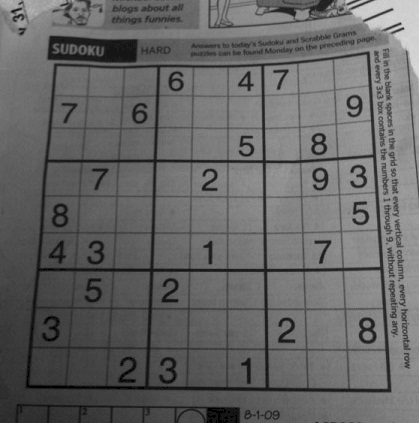

In [55]:
# last argument 1 is for rgb, 0 is for grayscale
img = cv2.imread('sudoku-original.png',0)
# display the image
cv2_imshow(img)

Plot the histogram of intensities:

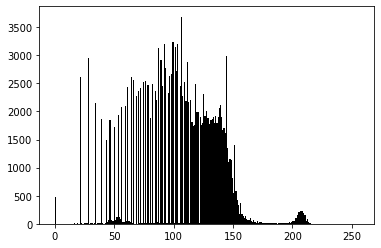

In [56]:
# Create 256 bins, plot from 0-256
plt.hist(img.flatten(),256,[0,256], color = 'k')

# use plt.show() to prevent extra output
plt.show()

Choose four appropriate points and perform a Perspective Transformation to obtain the sudoku as a proper square:

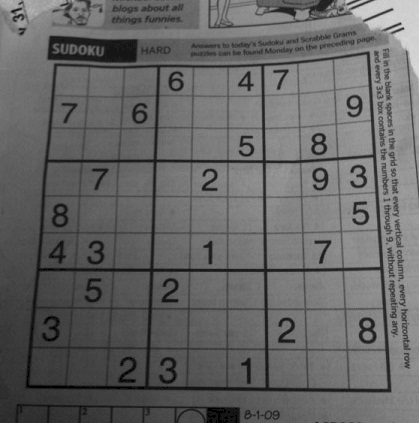

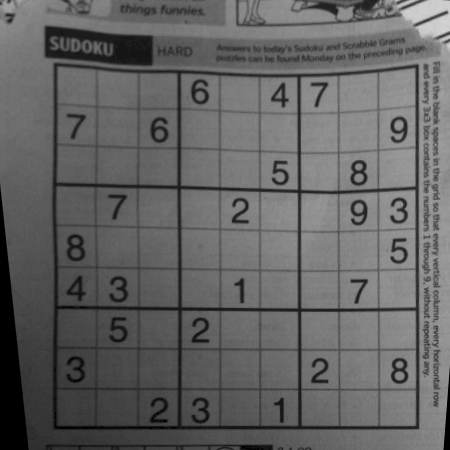

In [58]:
# source: https://www.educba.com/opencv-perspectivetransform/

# specify source coordinates (sc) as LL, LR, UL, UR
# I used paint to view the coordinates of the picture as pixel numbers
sc = np.float32([[27,386], [389,390], [55,65], [368,52]])

# specify destination coordinates (dc) as LL, LR, UL, UR based on:
# square side length = LR(x) - LL(x) = 362 pixels
# choose upper left corner as datum
dc = np.float32([[55,427], [417,427], [55,65], [417,65]])

# this is the line that creates a transformation matrix transformation
resmatrix = cv2.getPerspectiveTransform(sc, dc)

# this creates a results image using the original image and the 
# transformation matrix
resultimage = cv2.warpPerspective(img, resmatrix, (450, 450))

# shop the original image and transformed image
cv2_imshow(img)
cv2_imshow(resultimage)

# 2.2 Time Series

Load the data (energydata_complete.csv) and perform the following analysis. 

In [4]:
# Load the data using pandas
td = pd.read_csv('energydata_complete.csv')

Plot the appliances' energy consumption for whole period and a closer look at any one week of consumption:

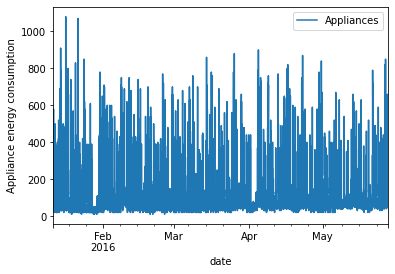

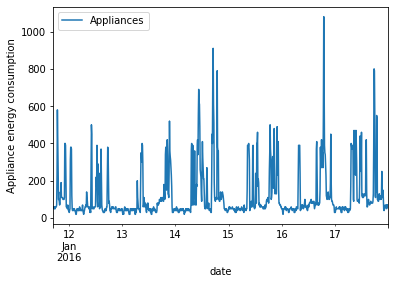

In [5]:
# turn date values from string to datetime so that it can be manipulated as a date
td['date'] = pd.to_datetime(td['date'])

# plot full data
td.plot(x='date', y='Appliances', 
              ylabel = "Appliance energy consumption")

# plot one week, first assign value of "week" to each row
td['week'] = td['date'].dt.isocalendar().week

# look specifically at second week
td[td['week'] == 2].plot(x='date', y='Appliances', 
                          ylabel = "Appliance energy consumption")
plt.show()

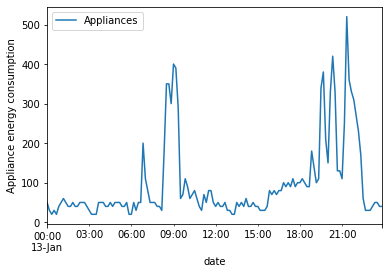

In [6]:
# that still looks somewhat crowded; plot one day:
# assign day to each - starts on Monday = 1
td['day'] = td['date'].dt.isocalendar().day
td.loc[((td['week'] == 2) & (td['day'] == 3))].plot(x='date', 
                                                     y='Appliances', 
                                                     ylabel = "Appliance energy consumption")
plt.show()

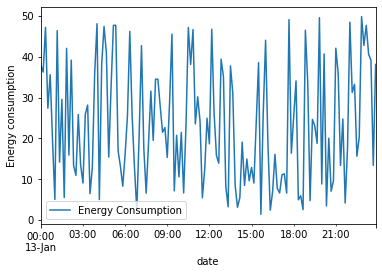

In [7]:
# I had originally tried this using the column for "Energy Consumption", but that
# seemed to give very sporadic results with no clear dependance upon time of day.
# This did not make sense to me, because I had expected to see some sort of 
# diurnal curve, which indicates a spike in the morning when people wake up, and 
# then a larger spike in the evening when they get home from work. We see this 
# pattern a lot in the water industry. (This is what causes correlation between
# energy use and the constructed variable NSM later in HW.)

# As shown below, when I used the "Energy Consumption" column I did not see this
# relationship, but when I switched to the "Appliances" column, shown above, I 
# did see it. While it could have been that the energy consumption was dominated
# by the air conditioner, AC would not likely be a dominant energy draw in 
# January in Belgium, where the data was collected. 

# For this reason, I chose to use the "Appliances" column data for 
# the remainder of the tasks in this section. 

td['day'] = td['date'].dt.isocalendar().day
td.loc[((td['week'] == 2) & (td['day'] == 3))].plot(x='date', 
                                                     y='Energy Consumption', 
                                                     ylabel = "Energy consumption")
plt.show()

Plot heatmap of hourly consumption of appliances for a week:

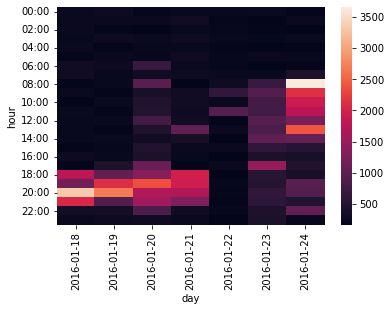

In [8]:
# source: https://stackoverflow.com/questions/64382010/how-to-create-a-seaborn-
# heatmap-by-hour-day-from-timestamp-with-multiple-data-po

# group data by week, day, and hour - then take mean of Energy Consumption 
# during each hour, creating a series of the hourly consumption with indexes 
# for week, day, and hour
s = (td.groupby([td.date.dt.isocalendar().week,
                 td.date.dt.strftime('%Y-%m-%d'), 
                 td.date.dt.strftime('%H:00')])
       ['Appliances'].sum()
       .rename_axis(index=['week','day','hour'])
    )

# look at week 3 
w = 3
sns.heatmap(s.loc[w].unstack(level='day'))
plt.show()

Plot the histogram of energy consumption of appliances:

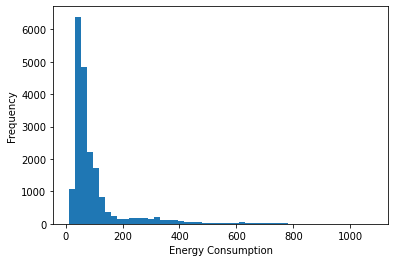

In [9]:
# set 50 bins for energy consumption data
# used raw values rather than hourly values
td['Appliances'].plot.hist(bins=50)
plt.xlabel('Energy Consumption')
plt.show()

Construct a feature variable NSM (no. seconds from midnight) and plot energy consumption vs. NSM:

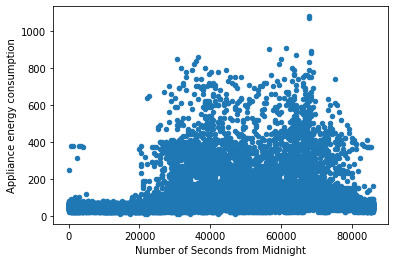

In [10]:
# assign value number of seconds from midnight (NSM) based on simple calculation
# NOTE: it was assumed that the variable ranged started from 0 at midnight and 
# increased over the course of the day up to 86,400 prior to midnight the next
# day. Another interpretation could have been that NSM increased until noon, and 
# then decreased as midnight got closer. However, this interpretation would not
# have given the diurnal lobes of increased energy consumption in morning and 
# afternoon.
td['NSM']=(td['date'].dt.hour*3600 + td['date'].dt.minute*60 
                 + td['date'].dt.second)

# plot as scatter plot
td.plot.scatter(x='NSM', y='Appliances', 
              ylabel = "Appliance energy consumption",
              xlabel = "Number of Seconds from Midnight")
plt.show()

Plot appliances energy consumption vs. Press_mm_HG:

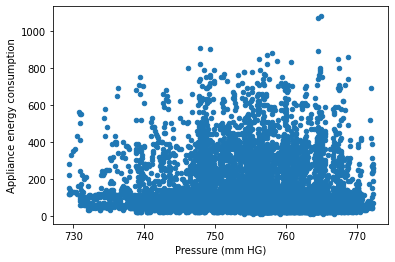

In [11]:
# plot as scatter plot
td.plot.scatter(x='Press_mm_hg', y='Appliances', 
              ylabel = "Appliance energy consumption",
              xlabel = "Pressure (mm HG)")
plt.show()

It is observed that the major contributing factor for the energy consumption among all other features is NSM and Press_mm_Hg. Comment on it. 

In [12]:
# Based on looking at the other factors, I could not tell visually what were the 
# major contributing factors. NSM does seem to be somewhat correlated as most 
# people are on similar schedules and I could see a faint diurnal pattern 
# (previously discussed), but by visual observation I did not think that 
# press_mm_hg was well correlated. 

# To check this, I looked at the correlation between the different columns of 
# the data frame. Only the first column of the output is of interest - that 
# for the Appliances row. 
print(td.corr())

# As can be seen, NSM did indeed have the highest positive correlation to 
# appliance energy consumpiton at 0.217, but Press_mm_Hg was poorly negatively
# correlated at -0.035. The other factors most correlated were the lights, which 
# were positively correlated at 0.197 and the RH_out, which I assume is relative
# humidity outside, which was negatively correlated at -0.152. It seems logical
# that the lights would be positively correlated, as people tend to use 
# appliances when the lights are on. The relative humidity seems less intuitive
# to me, but apparently this relationship has been previously documented. 
# (https://www.wemcouncil.org/wp/wp-content/uploads/2015/07/1230_YingChen.pdf)

                    Appliances    lights  ...       day       NSM
Appliances            1.000000  0.197278  ...  0.003060  0.217152
lights                0.197278  1.000000  ... -0.099828  0.254993
T1                    0.055447 -0.023528  ...  0.001381  0.178728
RH_1                  0.086031  0.106968  ... -0.053782  0.018531
T2                    0.120073 -0.005622  ...  0.000602  0.254569
RH_2                 -0.060465  0.050985  ... -0.044249 -0.183182
T3                    0.085060 -0.097393  ... -0.017514  0.037607
RH_3                  0.036292  0.131161  ... -0.035182 -0.052343
T4                    0.040281 -0.008859  ... -0.091006  0.088334
RH_4                  0.016965  0.114936  ... -0.005749 -0.019040
T5                    0.019760 -0.078745  ... -0.040827  0.071282
RH_5                  0.006955  0.141233  ...  0.008096  0.097242
T6                    0.117638 -0.079029  ...  0.026542  0.202892
RH_6                 -0.083178  0.153756  ...  0.010569 -0.190100
T7        

# 2.3 Multi-variate

Load the data and Compute the following descriptive statistics of the data:

In [13]:
# load data using pandas - previously loaded as pd
NASA = pd.read_csv('airfoil_self_noise.dat', sep="\s+", header = None)
type(NASA)

# name columns per HW description - this makes for clean printouts
cols = ["Frequency (HZ)", "Angle of Attack (deg)", "Chord Length (m)",
                "Free-stream Velocity (m/s)", 
                "Suction Side Displacement Thickness (m)",
                "Scaled Sound Pressure (db)"]
NASA.columns = cols
NASA

,Frequency (HZ),Angle of Attack (deg),Chord Length (m),Free-stream Velocity (m/s),Suction Side Displacement Thickness (m),Scaled Sound Pressure (db)
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461
...,...,...,...,...,...,...
1498,2500,15.6,0.1016,39.6,0.052849,110.264
1499,3150,15.6,0.1016,39.6,0.052849,109.254
1500,4000,15.6,0.1016,39.6,0.052849,106.604
1501,5000,15.6,0.1016,39.6,0.052849,106.224


Mean:

In [14]:
# create new object of calculated means using Pandas
# set axis to zero to calculate across columns
NASA_mean = NASA.mean(axis = 0)
NASA_mean


Frequency (HZ)                             2886.380572
Angle of Attack (deg)                         6.782302
Chord Length (m)                              0.136548
Free-stream Velocity (m/s)                   50.860745
Suction Side Displacement Thickness (m)       0.011140
Scaled Sound Pressure (db)                  124.835943
dtype: float64

Variance (or Standard Deviation):

In [15]:
# create new object of calculated variances using Pandas
# set axis to zero to calculate across columns
NASA_var = NASA.var(axis = 0)
NASA_var


Frequency (HZ)                             9.938717e+06
Angle of Attack (deg)                      3.502424e+01
Chord Length (m)                           8.749868e-03
Free-stream Velocity (m/s)                 2.425116e+02
Suction Side Displacement Thickness (m)    1.729287e-04
Scaled Sound Pressure (db)                 4.759146e+01
dtype: float64

Median:

In [16]:
# create new object of calculated median using Pandas
# set axis to zero to calculate across columns
NASA_med = NASA.median(axis = 0)
NASA_med

Frequency (HZ)                             1600.000000
Angle of Attack (deg)                         5.400000
Chord Length (m)                              0.101600
Free-stream Velocity (m/s)                   39.600000
Suction Side Displacement Thickness (m)       0.004957
Scaled Sound Pressure (db)                  125.721000
dtype: float64

Kurtosis:

In [17]:
# create new object of calculated kurtosis using Pandas
# set axis to zero to calculate across columns
NASA_kurt = NASA.kurtosis(axis = 0)
NASA_kurt

# Interestingly, the kurtosis and skewness results 
# using scipy were slightly different, likely due to different
# default settings and methods of calculation

Frequency (HZ)                             5.708685
Angle of Attack (deg)                     -0.412951
Chord Length (m)                          -1.037964
Free-stream Velocity (m/s)                -1.563951
Suction Side Displacement Thickness (m)    2.218903
Scaled Sound Pressure (db)                -0.314187
dtype: float64

Skewness:

In [18]:
# create new object of calculated skewness using Pandas
# set axis to zero to calculate across columns
NASA_skew = NASA.skew(axis = 0)
NASA_skew

Frequency (HZ)                             2.137084
Angle of Attack (deg)                      0.689164
Chord Length (m)                           0.457457
Free-stream Velocity (m/s)                 0.235852
Suction Side Displacement Thickness (m)    1.702165
Scaled Sound Pressure (db)                -0.418952
dtype: float64

Range:

In [19]:
# create new objects of calculated minimums and maximums using Pandas
# set axis to zero to calculate across columns
NASA_min = NASA.min(axis = 0)
NASA_max = NASA.max(axis = 0)

# convert min values from string to dataframe to which we will append max values
NASA_range = NASA_min.to_frame()

# append max values
NASA_range['Max'] = NASA_max

# set names for new dataframe columns
NASA_range.columns = ['Minimum Value', 'Maximum Value']
NASA_range

,Minimum Value,Maximum Value
Frequency (HZ),200.000000,20000.000000
Angle of Attack (deg),0.000000,22.200000
Chord Length (m),0.025400,0.304800
Free-stream Velocity (m/s),31.700000,71.300000
Suction Side Displacement Thickness (m),0.000401,0.058411
Scaled Sound Pressure (db),103.380000,140.987000
